In [2]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
int(10006/10)

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [10, 40, 100, 500]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/pcc/0/all_bins/KR_KR/inter_only/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        GO_groups = pd.read_csv('/data/bharris/GO_data/aug4.GOslim', names=["go_id"])

        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        for go_id in GO_groups["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)
                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)

        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list)), columns=['id', 'P_val_agg', 'U1_stat'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234


ValueError: left cannot be >= right

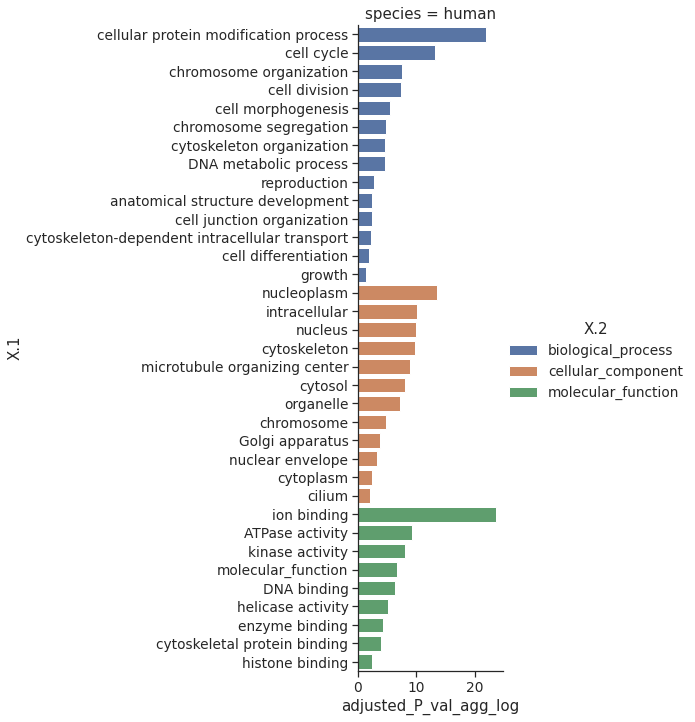

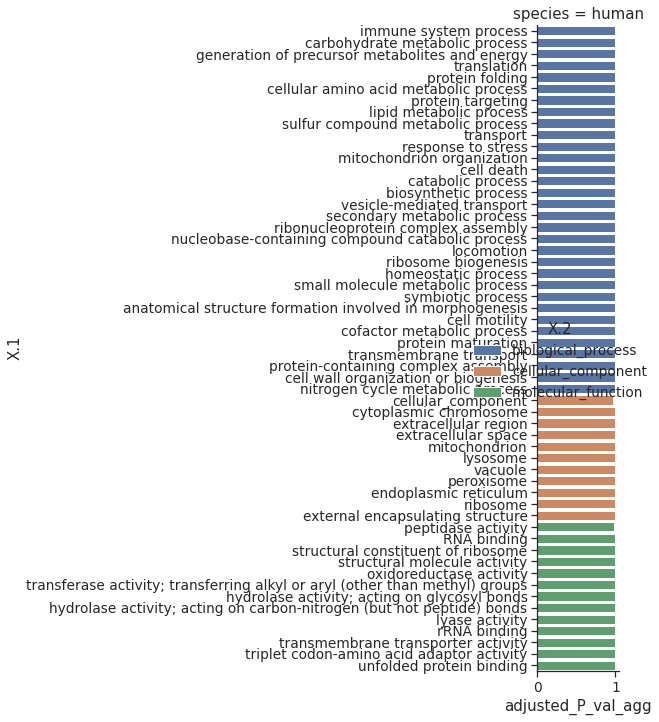

In [19]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp[0:1]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


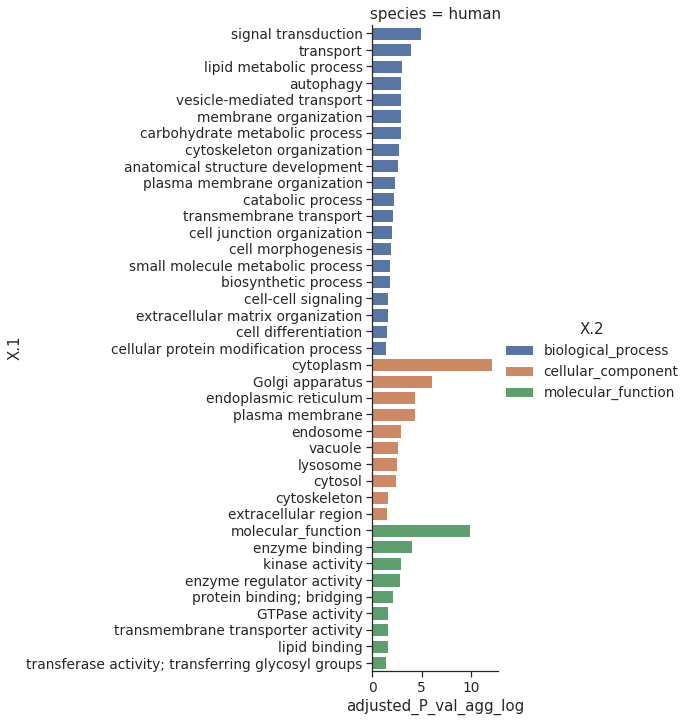

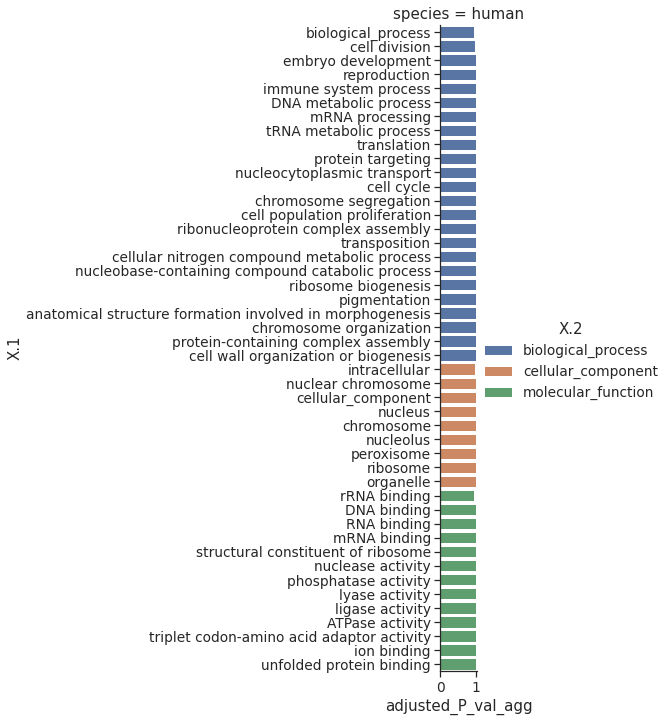

In [17]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp[3:4]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


In [20]:
df_whole

Unnamed: 0           X                                   X.1  \
0             3  GO:0000003                          reproduction   
1           197  GO:0000228                    nuclear chromosome   
2           198  GO:0000229                cytoplasmic chromosome   
3           584  GO:0000902                    cell morphogenesis   
4          1697  GO:0002376                 immune system process   
..          ...         ...                                   ...   
130       29481  GO:0055085               transmembrane transport   
131       30532  GO:0061024                 membrane organization   
132       31612  GO:0065003   protein-containing complex assembly   
133       33151  GO:0071554  cell wall organization or biogenesis   
134       33522  GO:0071941      nitrogen cycle metabolic process   

                    X.2          id     P_val_agg     U1_stat species  \
0    biological_process  GO:0000003  3.260722e-04   8878342.5   human   
1    cellular_component  GO:0000228  1.904544e-01   7538276.0   human   
2    cellular_component  GO:0000229  9.298719e-01      1157.0   human   
3    biological_process  GO:0000902  3.603516e-07   5562600.0   human   
4    biological_process  GO:0002376  1.000000e+00  13695890.5   human   
..                  ...         ...           ...         ...     ...   
130  biological_process  GO:0055085  9.800184e-01   7817692.0   human   
131  biological_process  GO:0061024  6.834654e-02   5793653.0   human   
132  biological_process  GO:0065003  9.569745e-01   8324295.0   human   
133  biological_process  GO:0071554  9.733207e-01     13783.0   human   
134  biological_process  GO:0071941  6.855799e-01     56173.0   human   

     adjusted_P_val_agg  adjusted_P_val_agg_log  
0              0.001630                2.787716  
1              0.451076                0.345750  
2              1.000000               -0.000000  
3              0.000003                5.543389  
4              1.000000               -0.000000  
..                  ...                     ...  
130            1.000000               -0.000000  
131            0.192225                0.716191  
132            1.000000               -0.000000  
133            1.000000               -0.000000  
134            1.000000               -0.000000  

[135 rows x 10 columns]

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp_agg = []
for resolution in [10, 40, 100, 500]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/pcc/0/all_bins/KR_KR/inter_only/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        GO_groups = pd.read_csv('/data/bharris/GO_data/aug4.GOslim', names=["go_id"])

        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        for go_id in GO_groups["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)
                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)

        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list)), columns=['id', 'P_val_agg', 'U1_stat'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp_agg.append(auc_GO_terms_manw)


GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234
GO:0000988
GO:0001071
GO:0004871
GO:0005578
GO:0005618
GO:0006461
GO:0007067
GO:0008565
GO:0009536
GO:0009579
GO:0015979
GO:0016023
GO:0030555
GO:0043234


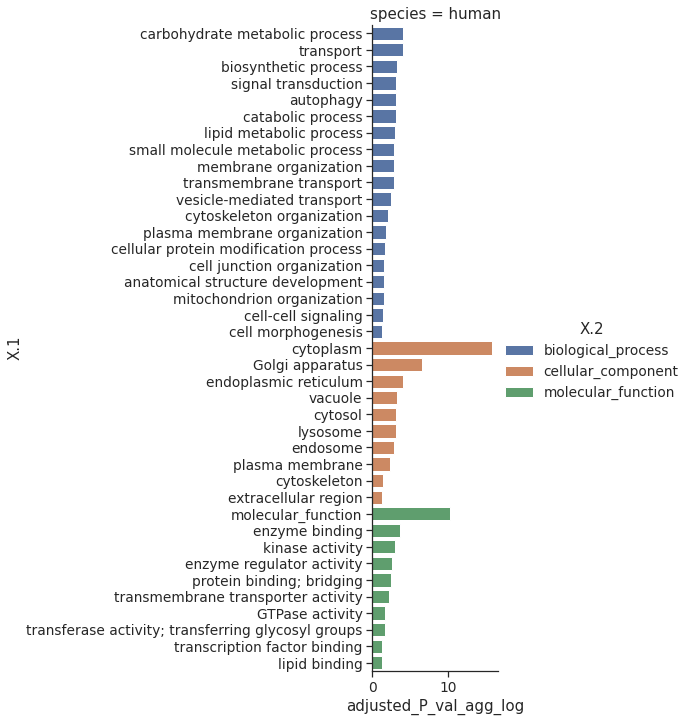

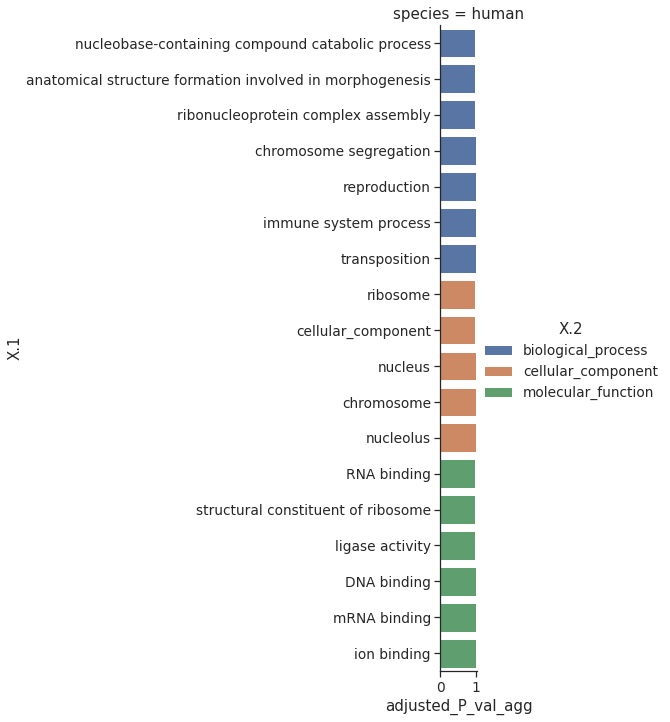

In [18]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp_agg[3:4]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')

    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp_agg_spr = []
species="human"
for resolution in [10, 40, 500]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/inter_only/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])
        


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')

        print (df_hic_auc)
        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        
        GO_groups = pd.read_csv('/data/bharris/GO_data/aug4.GOslim', names=["go_id"])

        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        for go_id in GO_groups["go_id"].tolist():
            #print (go_id)
        #for go_id in df['GO_term'].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                    
                    if len(t_p_scores) > 10 :
                        if len(t_p_scores) <= 300 :
                            print (len(t_p_scores))
                            U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                            #nx, ny = len(t_p_scores), len(t_n_scores)
                            #N = nx + ny
                            #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                            #p = stats.norm.sf(z)
                            z_list.append(U1)
                            z_p_dict.append(p_val)
                        else:
                            print ("t")
                            
                            z_list.append(np.nan)
                            z_p_dict.append(np.nan)
                            #print (p, p_val)
                        

                    else:
                        print ("t")
                        
                        z_list.append(np.nan)
                        z_p_dict.append(np.nan)
            except:
                print ("i")
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)

        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list)), columns=['id', 'P_val_agg', 'U1_stat'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp_agg_spr.append(auc_GO_terms_manw)


       gene_id_jac_sim chrom_jac_sim gene_id_exp_file chrom_exp_file       auc
0      ENSG00000234500          chr7  ENSG00000234500           chr7  0.772186
1      ENSG00000196110         chr19  ENSG00000196110          chr19  0.375609
2      ENSG00000250045          chr5  ENSG00000250045           chr5  0.514181
3      ENSG00000168421          chr4  ENSG00000168421           chr4  0.581972
4      ENSG00000135749          chr1  ENSG00000135749           chr1  0.691990
...                ...           ...              ...            ...       ...
23460  ENSG00000268322         chr19  ENSG00000268322          chr19  0.456466
23461  ENSG00000213700         chr10  ENSG00000213700          chr10  0.402731
23462  ENSG00000198730         chr11  ENSG00000198730          chr11  0.727712
23463  ENSG00000066422          chr3  ENSG00000066422           chr3  0.639220
23464  ENSG00000206838          chr7  ENSG00000206838           chr7  0.616880

[23465 rows x 5 columns]
t
t
t
t
i
GO:0000988
i
GO:

In [15]:
go_df_scores['GO:0005515'].sum()

12005.0

In [16]:
go_df_scores

GO:0000002  GO:0000003  GO:0000009  GO:0000010  GO:0000012  GO:0000014  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
15584         0.0         0.0         0.0         0.0         0.0         0.0   
15585         0.0         0.0         0.0         0.0         0.0         0.0   
15586         0.0         0.0         0.0         0.0         0.0         0.0   
15587         0.0         0.0         0.0         0.0         0.0         0.0   
15588         0.0         0.0         0.0         0.0         0.0         0.0   

       GO:0000015  GO:0000016  GO:0000017  GO:0000018  ...  GO:2001302  \
0             0.0         0.0         0.0         0.0  ...         0.0   
1             0.0         0.0         0.0         0.0  ...         0.0   
2             0.0         0.0         0.0         0.0  ...         0.0   
3             0.0         0.0         0.0         0.0  ...         0.0   
4             0.0         0.0         0.0         0.0  ...         0.0   
...           ...         ...         ...         ...  ...         ...   
15584         0.0         0.0         0.0         0.0  ...         0.0   
15585         0.0         0.0         0.0         0.0  ...         0.0   
15586         0.0         0.0         0.0         0.0  ...         0.0   
15587         0.0         0.0         0.0         0.0  ...         0.0   
15588         0.0         0.0         0.0         0.0  ...         0.0   

       GO:2001303  GO:2001304  GO:2001306  GO:2001311  gene_id_jac_sim  \
0             0.0         0.0         0.0         0.0  ENSG00000000419   
1             0.0         0.0         0.0         0.0  ENSG00000000457   
2             0.0         0.0         0.0         0.0  ENSG00000000460   
3             0.0         0.0         0.0         0.0  ENSG00000000938   
4             0.0         0.0         0.0         0.0  ENSG00000000971   
...           ...         ...         ...         ...              ...   
15584         0.0         0.0         0.0         0.0  ENSG00000285130   
15585         0.0         0.0         0.0         0.0  ENSG00000285253   
15586         0.0         0.0         0.0         0.0  ENSG00000285269   
15587         0.0         0.0         0.0         0.0  ENSG00000285437   
15588         0.0         0.0         0.0         0.0  ENSG00000285509   

       chrom_jac_sim  gene_id_exp_file  chrom_exp_file       auc  
0              chr20   ENSG00000000419           chr20  0.453332  
1               chr1   ENSG00000000457            chr1  0.641800  
2               chr1   ENSG00000000460            chr1  0.664265  
3               chr1   ENSG00000000938            chr1  0.667590  
4               chr1   ENSG00000000971            chr1  0.694897  
...              ...               ...             ...       ...  
15584           chr9   ENSG00000285130            chr9  0.592828  
15585          chr15   ENSG00000285253           chr15  0.604433  
15586           chr9   ENSG00000285269            chr9  0.667973  
15587           chr7   ENSG00000285437            chr7  0.623397  
15588          chr11   ENSG00000285509           chr11  0.522466  

[15589 rows x 22931 columns]

In [ ]:
go_df_scores.index()

In [53]:
go_df_scores

GO:0000002  GO:0000003  GO:0000009  GO:0000010  GO:0000012  GO:0000014  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
15584         0.0         0.0         0.0         0.0         0.0         0.0   
15585         0.0         0.0         0.0         0.0         0.0         0.0   
15586         0.0         0.0         0.0         0.0         0.0         0.0   
15587         0.0         0.0         0.0         0.0         0.0         0.0   
15588         0.0         0.0         0.0         0.0         0.0         0.0   

       GO:0000015  GO:0000016  GO:0000017  GO:0000018  ...  GO:2001302  \
0             0.0         0.0         0.0         0.0  ...         0.0   
1             0.0         0.0         0.0         0.0  ...         0.0   
2             0.0         0.0         0.0         0.0  ...         0.0   
3             0.0         0.0         0.0         0.0  ...         0.0   
4             0.0         0.0         0.0         0.0  ...         0.0   
...           ...         ...         ...         ...  ...         ...   
15584         0.0         0.0         0.0         0.0  ...         0.0   
15585         0.0         0.0         0.0         0.0  ...         0.0   
15586         0.0         0.0         0.0         0.0  ...         0.0   
15587         0.0         0.0         0.0         0.0  ...         0.0   
15588         0.0         0.0         0.0         0.0  ...         0.0   

       GO:2001303  GO:2001304  GO:2001306  GO:2001311  gene_id_jac_sim  \
0             0.0         0.0         0.0         0.0  ENSG00000000419   
1             0.0         0.0         0.0         0.0  ENSG00000000457   
2             0.0         0.0         0.0         0.0  ENSG00000000460   
3             0.0         0.0         0.0         0.0  ENSG00000000938   
4             0.0         0.0         0.0         0.0  ENSG00000000971   
...           ...         ...         ...         ...              ...   
15584         0.0         0.0         0.0         0.0  ENSG00000285130   
15585         0.0         0.0         0.0         0.0  ENSG00000285253   
15586         0.0         0.0         0.0         0.0  ENSG00000285269   
15587         0.0         0.0         0.0         0.0  ENSG00000285437   
15588         0.0         0.0         0.0         0.0  ENSG00000285509   

       chrom_jac_sim  gene_id_exp_file  chrom_exp_file       auc  
0              chr20   ENSG00000000419           chr20  0.453332  
1               chr1   ENSG00000000457            chr1  0.641800  
2               chr1   ENSG00000000460            chr1  0.664265  
3               chr1   ENSG00000000938            chr1  0.667590  
4               chr1   ENSG00000000971            chr1  0.694897  
...              ...               ...             ...       ...  
15584           chr9   ENSG00000285130            chr9  0.592828  
15585          chr15   ENSG00000285253           chr15  0.604433  
15586           chr9   ENSG00000285269            chr9  0.667973  
15587           chr7   ENSG00000285437            chr7  0.623397  
15588          chr11   ENSG00000285509           chr11  0.522466  

[15589 rows x 22931 columns]

In [25]:
auc_GO_terms_manw_three_list_hic_exp_agg_spr[0]

id  P_val_agg     U1_stat species  adjusted_P_val_agg
0    GO:0000003   0.972603   8092140.0   human            0.999875
1    GO:0000228   0.336131   7475366.0   human            0.515656
2    GO:0000229   0.158127     12304.0   human            0.315485
3    GO:0000902   0.000879   5354349.5   human            0.004239
6    GO:0002376   0.999980  14023130.5   human            1.000000
..          ...        ...         ...     ...                 ...
144  GO:0055085   0.001610   8543772.0   human            0.006588
145  GO:0061024   0.000060   6078385.0   human            0.000353
146  GO:0065003   0.382086   8625408.0   human            0.543201
147  GO:0071554   0.741987     25325.0   human            0.841750
148  GO:0071941   0.307480     68725.0   human            0.497165

[135 rows x 5 columns]

In [1]:
t_p_scores

NameError: name 't_p_scores' is not defined

In [39]:
len(go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist())

8

In [29]:
go_df_scores[go_id]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15584    0.0
15585    0.0
15586    0.0
15587    0.0
15588    0.0
Name: GO:0071941, Length: 15589, dtype: float64

In [27]:
go_df_scores

GO:0000002  GO:0000003  GO:0000009  GO:0000010  GO:0000012  GO:0000014  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
15584         0.0         0.0         0.0         0.0         0.0         0.0   
15585         0.0         0.0         0.0         0.0         0.0         0.0   
15586         0.0         0.0         0.0         0.0         0.0         0.0   
15587         0.0         0.0         0.0         0.0         0.0         0.0   
15588         0.0         0.0         0.0         0.0         0.0         0.0   

       GO:0000015  GO:0000016  GO:0000017  GO:0000018  ...  GO:2001302  \
0             0.0         0.0         0.0         0.0  ...         0.0   
1             0.0         0.0         0.0         0.0  ...         0.0   
2             0.0         0.0         0.0         0.0  ...         0.0   
3             0.0         0.0         0.0         0.0  ...         0.0   
4             0.0         0.0         0.0         0.0  ...         0.0   
...           ...         ...         ...         ...  ...         ...   
15584         0.0         0.0         0.0         0.0  ...         0.0   
15585         0.0         0.0         0.0         0.0  ...         0.0   
15586         0.0         0.0         0.0         0.0  ...         0.0   
15587         0.0         0.0         0.0         0.0  ...         0.0   
15588         0.0         0.0         0.0         0.0  ...         0.0   

       GO:2001303  GO:2001304  GO:2001306  GO:2001311  gene_id_jac_sim  \
0             0.0         0.0         0.0         0.0  ENSG00000000419   
1             0.0         0.0         0.0         0.0  ENSG00000000457   
2             0.0         0.0         0.0         0.0  ENSG00000000460   
3             0.0         0.0         0.0         0.0  ENSG00000000938   
4             0.0         0.0         0.0         0.0  ENSG00000000971   
...           ...         ...         ...         ...              ...   
15584         0.0         0.0         0.0         0.0  ENSG00000285130   
15585         0.0         0.0         0.0         0.0  ENSG00000285253   
15586         0.0         0.0         0.0         0.0  ENSG00000285269   
15587         0.0         0.0         0.0         0.0  ENSG00000285437   
15588         0.0         0.0         0.0         0.0  ENSG00000285509   

       chrom_jac_sim  gene_id_exp_file  chrom_exp_file       auc  
0              chr20   ENSG00000000419           chr20  0.453332  
1               chr1   ENSG00000000457            chr1  0.641800  
2               chr1   ENSG00000000460            chr1  0.664265  
3               chr1   ENSG00000000938            chr1  0.667590  
4               chr1   ENSG00000000971            chr1  0.694897  
...              ...               ...             ...       ...  
15584           chr9   ENSG00000285130            chr9  0.592828  
15585          chr15   ENSG00000285253           chr15  0.604433  
15586           chr9   ENSG00000285269            chr9  0.667973  
15587           chr7   ENSG00000285437            chr7  0.623397  
15588          chr11   ENSG00000285509           chr11  0.522466  

[15589 rows x 22931 columns]

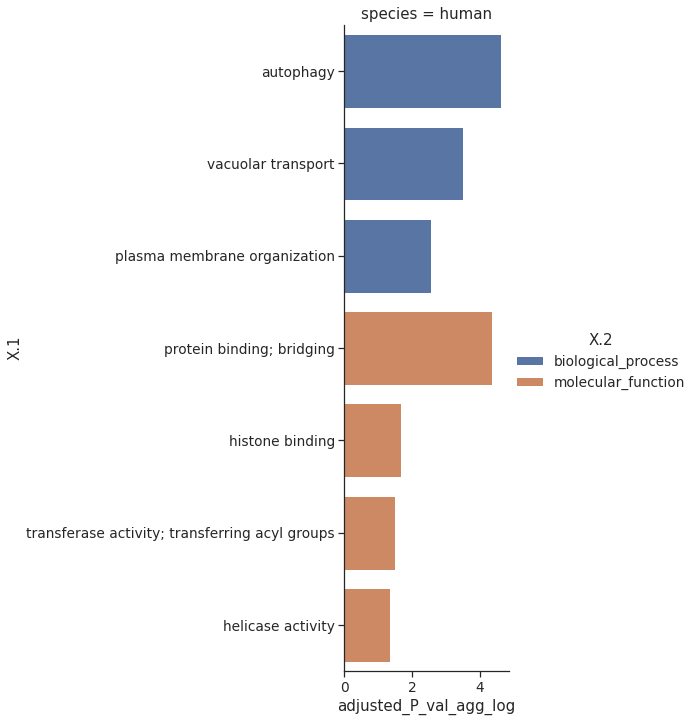

In [32]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp_agg_spr[0:1]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')

    #sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


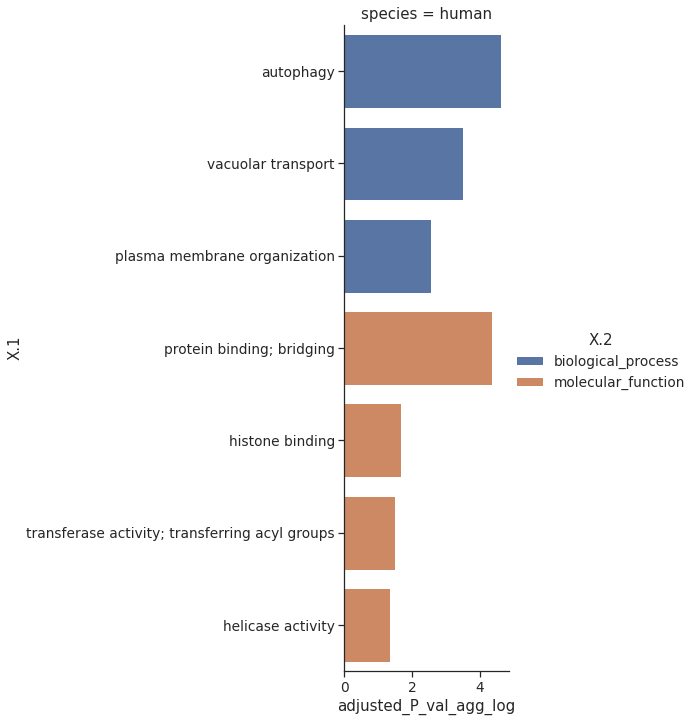

In [39]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp_agg_spr[0:1]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')

    #sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


In [19]:
df_whole

Unnamed: 0           X                                                X.1  \
0         2750  GO:0003729                                       mRNA binding   
1         2756  GO:0003735                 structural constituent of ribosome   
2         2906  GO:0003924                                    GTPase activity   
3         3315  GO:0004386                                  helicase activity   
4         3429  GO:0004518                                  nuclease activity   
5         4433  GO:0005777                                         peroxisome   
6         4466  GO:0005811                                      lipid droplet   
7         4492  GO:0005840                                           ribosome   
8         4997  GO:0006399                             tRNA metabolic process   
9         5044  GO:0006457                                    protein folding   
10        5100  GO:0006520              cellular amino acid metabolic process   
11        5460  GO:0006913                        nucleocytoplasmic transport   
12        5461  GO:0006914                                          autophagy   
13        5540  GO:0007009                       plasma membrane organization   
14        5560  GO:0007034                                 vacuolar transport   
15        5582  GO:0007059                             chromosome segregation   
16        6041  GO:0007568                                              aging   
17        6224  GO:0008135           translation factor activity; RNA binding   
18        6255  GO:0008168                         methyltransferase activity   
19       10617  GO:0016746     transferase activity; transferring acyl groups   
20       10628  GO:0016757  transferase activity; transferring glycosyl gr...   
21       10636  GO:0016765  transferase activity; transferring alkyl or ar...   
22       10648  GO:0016779                    nucleotidyltransferase activity   
23       10658  GO:0016791                               phosphatase activity   
24       10664  GO:0016798       hydrolase activity; acting on glycosyl bonds   
25       10674  GO:0016810  hydrolase activity; acting on carbon-nitrogen ...   
26       10692  GO:0016829                                     lyase activity   
27       10716  GO:0016853                                 isomerase activity   
28       10737  GO:0016874                                    ligase activity   
29       12609  GO:0019748                        secondary metabolic process   
30       12700  GO:0019843                                       rRNA binding   
31       13056  GO:0021700                           developmental maturation   
32       13426  GO:0022618                 ribonucleoprotein complex assembly   
33       14168  GO:0030674                          protein binding; bridging   
34       14198  GO:0030705     cytoskeleton-dependent intracellular transport   
35       15602  GO:0032182                     ubiquitin-like protein binding   
36       20517  GO:0042254                                ribosome biogenesis   
37       20641  GO:0042393                                    histone binding   
38       21594  GO:0043473                                       pigmentation   
39       27694  GO:0051082                           unfolded protein binding   
40       28180  GO:0051604                                 protein maturation   

                   X.2          id  P_val_agg    U1_stat species  \
0   molecular_function  GO:0003729   0.617825  2076021.0   human   
1   molecular_function  GO:0003735   0.370924  1183697.0   human   
2   molecular_function  GO:0003924   0.007128  2420052.5   human   
3   molecular_function  GO:0004386   0.313030  1184653.0   human   
4   molecular_function  GO:0004518   0.598225  1508057.0   human   
5   cellular_component  GO:0005777   0.779022   905417.0   human   
6   cellular_component  GO:0005811   0.028114   729747.0   human   
7   cellular_component  GO:0005840   0.399877  1676945.0 

In [17]:
auc_GO_terms_manw

id  P_val_agg    U1_stat species  adjusted_P_val_agg
11   GO:0003729   0.617825  2076021.0   human            0.723738
12   GO:0003735   0.370924  1183697.0   human            0.594554
13   GO:0003924   0.007128  2420052.5   human            0.070999
14   GO:0004386   0.313030  1184653.0   human            0.594554
15   GO:0004518   0.598225  1508057.0   human            0.723183
35   GO:0005777   0.779022   905417.0   human            0.822633
38   GO:0005811   0.028114   729747.0   human            0.164667
41   GO:0005840   0.399877  1676945.0   human            0.607220
49   GO:0006399   0.517437  1338524.0   human            0.723183
51   GO:0006457   0.039982  1618132.0   human            0.189958
54   GO:0006520   0.478336  1989137.0   human            0.700421
59   GO:0006913   0.599713  1824405.0   human            0.723183
60   GO:0006914   0.000005  2325914.5   human            0.000218
63   GO:0007009   0.002135   810723.0   human            0.029172
65   GO:0007034   0.008658  1142692.0   human            0.070999
67   GO:0007059   0.854438  1791061.0   human            0.875799
72   GO:0007568   0.051198  2017116.0   human            0.209913
75   GO:0008135   0.323232   677899.0   human            0.594554
77   GO:0008168   0.359149  1569361.0   human            0.594554
93   GO:0016746   0.070202  1889489.0   human            0.261664
94   GO:0016757   0.018096  2041717.0   human            0.123654
95   GO:0016765   0.651092   383761.0   human            0.741521
96   GO:0016779   0.114733   987155.0   human            0.392006
97   GO:0016791   0.574125  1941765.0   human            0.723183
98   GO:0016798   0.124324   961058.0   human            0.392098
99   GO:0016810   0.160567   921684.0   human            0.411453
100  GO:0016829   0.579620  1420221.0   human            0.723183
101  GO:0016853   0.208249  1147914.0   human            0.474344
102  GO:0016874   0.718570  1065850.0   human            0.796253
104  GO:0019748   0.587626   350740.0   human            0.723183
105  GO:0019843   0.342293   480003.0   human            0.594554
107  GO:0021700   0.183973  1696272.0   human            0.443699
109  GO:0022618   0.881129  1449421.0   human            0.881129
117  GO:0030674   0.000334  2085265.0   human            0.006857
118  GO:0030705   0.317980  1453672.0   human            0.594554
119  GO:0032182   0.138462   759655.0   human            0.405497
126  GO:0042254   0.158218  2218020.0   human            0.411453
127  GO:0042393   0.041698  1671964.5   human            0.189958
132  GO:0043473   0.782505   619097.0   human            0.822633
139  GO:0051082   0.294326   798709.0   human            0.594554
143  GO:0051604   0.377034  1558710.0   human            0.594554

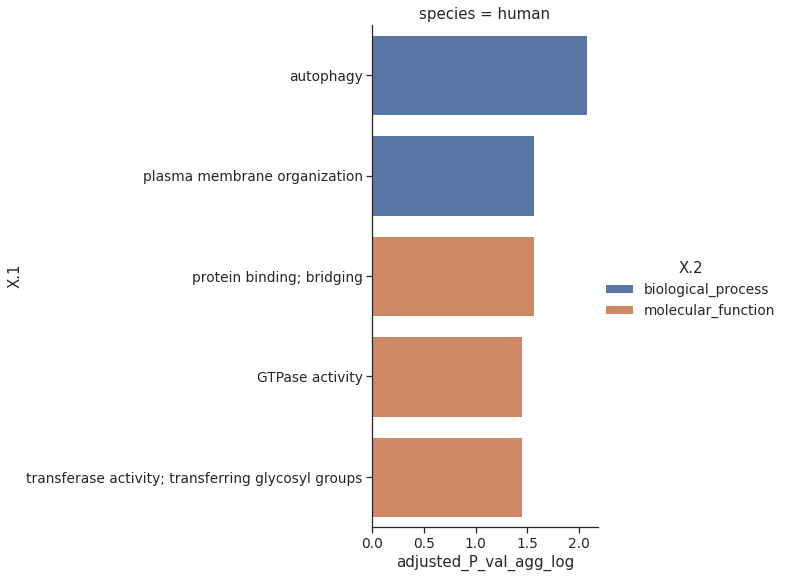

In [38]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp_agg_spr[2:3]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=8, aspect=6/5, kind='bar', dodge=False, col='species')

    #sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')


In [ ]:
auc_GO_terms_manw.head()

In [24]:
ruchi lohia is inviting you to a scheduled Zoom meeting.

Topic: ruchi lohia's Personal Meeting Room

Join Zoom Meeting
https://us04web.zoom.us/j/2737256648?pwd=R1NLUjEzUmFBalk3eXVZZkpXc1hOUT09

Meeting ID: 273 725 6648
Passcode: 290579



SyntaxError: invalid syntax (<ipython-input-24-7ba6925f093a>, line 1)

In [ ]:
g

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp_agg_spr_ind = []
species="human"
for resolution in [10, 500]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/inter_only/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])
        


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')

        print (df_hic_auc)
        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        
        GO_groups = pd.read_csv('/data/bharris/GO_data/aug4.GOslim', names=["go_id"])

        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        for go_id in GO_groups["go_id"].tolist():
            #print (go_id)
        #for go_id in df['GO_term'].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc'].tolist()
                    
                    if len(t_p_scores) > 10 :
                        if len(t_p_scores) <= 300 :
                            print (len(t_p_scores))
                            U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                            #nx, ny = len(t_p_scores), len(t_n_scores)
                            #N = nx + ny
                            #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                            #p = stats.norm.sf(z)
                            z_list.append(U1)
                            z_p_dict.append(p_val)
                        else:
                            print ("t")
                            
                            z_list.append(np.nan)
                            z_p_dict.append(np.nan)
                            #print (p, p_val)
                        

                    else:
                        print ("t")
                        
                        z_list.append(np.nan)
                        z_p_dict.append(np.nan)
            except:
                print ("i")
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)

        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list)), columns=['id', 'P_val_agg', 'U1_stat'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp_agg_spr_ind.append(auc_GO_terms_manw)


       gene_id_jac_sim chrom_jac_sim gene_id_exp_file chrom_exp_file       auc
0      ENSG00000170379          chr7  ENSG00000170379           chr7  0.760152
1      ENSG00000279118          chr5  ENSG00000279118           chr5  0.661204
2      ENSG00000137504         chr11  ENSG00000137504          chr11  0.758153
3      ENSG00000240373          chr3  ENSG00000240373           chr3  0.735385
4      ENSG00000261195         chr16  ENSG00000261195          chr16  0.683966
...                ...           ...              ...            ...       ...
23460  ENSG00000242193          chr1  ENSG00000242193           chr1  0.721847
23461  ENSG00000089009         chr12  ENSG00000089009          chr12  0.507864
23462  ENSG00000176402          chr7  ENSG00000176402           chr7  0.670501
23463  ENSG00000226705         chr10  ENSG00000226705          chr10  0.359011
23464  ENSG00000230439          chr1  ENSG00000230439           chr1  0.770214

[23465 rows x 5 columns]
t
t
t
t
i
GO:0000988
i
GO:

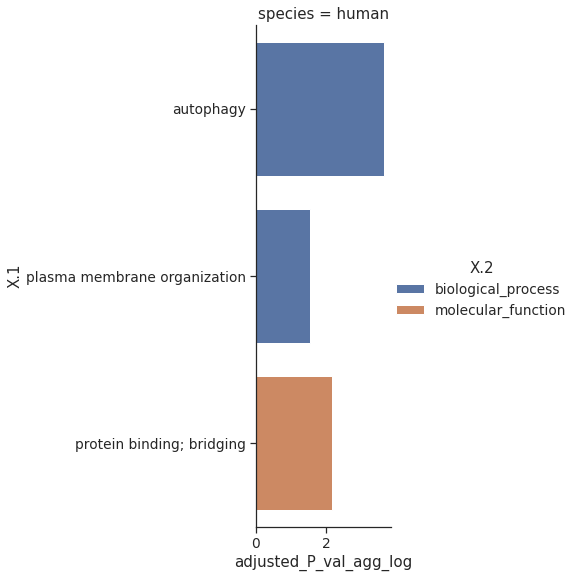

In [36]:
for list_type in [auc_GO_terms_manw_three_list_hic_exp_agg_spr[1:2]]:
    auc_GO_terms_manw = pd.concat(list_type)

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(auc_GO_terms_manw, left_on='X', right_on='id')

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['adjusted_P_val_agg']]
    sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] <= 0.05].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=8, aspect=5/6, kind='bar', dodge=False, col='species')

    #sns.catplot(data=df_whole[df_whole['adjusted_P_val_agg'] >= 0.95].sort_values(['X.2', 'adjusted_P_val_agg']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False, col='species')
